## Before reading anything

- run the cell below so all the dependencies can precompile as you read the introduction. Plots and DiffEqParamEstim can take a long time.

In [2]:
using MyModelMenagerie, OrdinaryDiffEq, Plots, FiniteDiff, DiffEqParamEstim;

# Introductory example


### Analysing a forced harmonic oscillator

Here we are going to analyse to death a **really simple** example. One where minimally disruptive (MD) curves can be evolved in fractions of a second. This allows you to play around with all the different features of MinimallyDisruptiveCurves.jl and get immediate feedback.

Points that will be covered in this tutorial:

- Load prebuilt models from the MyModelMenagerie.jl repository.
- Build a differentiable cost function using DiffEqParamEstim.jl.
- Evolve a (two-sided) minimally disruptive curve using a cost function and an initial set of parameters.
- Sum cost functions (useful if we want to investigate behaviours of a model for multiple inputs, each of which has its own cost function)



### Background

A harmonic oscillator is the simplest differential equation model on which we can demonstrate how to find a minimally disruptive curve. The differential equation is provided below:

$$ m\ddot{x}(t) + c \dot{x}(t) + kx(t) = F(t). $$

Physically, this models a mass bouncing up and down on a spring, while being forced by an input $F(t)$. Here $[m,c,k]$ are the mass, damping-coefficient, and spring constant, respectively. $[x(t), \dot{x}(t), \ddot{x}(t)]$ are the position, velocity, and acceleration at time $t$.

Let's first consider the case where $F(t) = 0$. So we have
$$ m\ddot{x}(t) + c \dot{x}(t) + kx(t) = 0. $$

We can immediately see that the equation doesn't change if we divide through by $m$:

$$ \ddot{x}(t) + \frac{c}{m} \dot{x}(t) + \frac{k}{m}x(t) = 0. $$

So for the no-input case, we can see that the model is **invariant** to changes that preserve $\frac{c}{m}$ and $\frac{k}{m}$. 

Let's take $\theta$ as the vector of parameters $[m,c,k]$, and $\theta^*$ as a 'nominal' parameter vector. Evolving a minimally disruptive curve equates to generating a parameterised curve $\theta(s)$ that preserves $\frac{c}{m} = \frac{c^*}{m^*}$ and $\frac{k}{m} = \frac{k^*}{m^*}$, since any point on this curve represents a parameter set which gives identical model behaviour as $\theta^*$. 

### Building the model

I've made the model for you, in MyModelMenagerie.jl. Take it for a spin:

In [25]:
using MyModelMenagerie
od,ic,tspan, θs = MassSpringOscillator(t->0.);
# od: system of ordinary differential equations
# ic: initial conditions
# tspan: time span to run over
# θs: parameters
using Latexify
latexify(od)

L"$\begin{align}
\frac{dpos(t)}{dt} =& \mathrm{vel}\left( t \right) \\
\frac{dvel(t)}{dt} =& \frac{-1}{m} \left( c \mathrm{vel}\left( t \right) + k \mathrm{pos}\left( t \right) - 0.0 \right)
\end{align}
$"

- The MyModelMenagerie models are built using [ModelingToolkit.jl](https://mtk.sciml.ai).

- ```t->0.``` is a function representing the input. You can change to any function of ```t``` that you like.

Let's arbitrarily change ic, tspan and ps, just so you can see how.

In [4]:
tspan = (0., 100.)
θs = first.(θs) .=> [2.,1.,4.]
ic = first.(ic) .=> [1.,0.]


2-element Array{Pair{ModelingToolkit.Operation,Float64},1}:
 pos(t) => 1.0
 vel(t) => 0.0

Now let's turn the model into a differential equation, and solve it. 

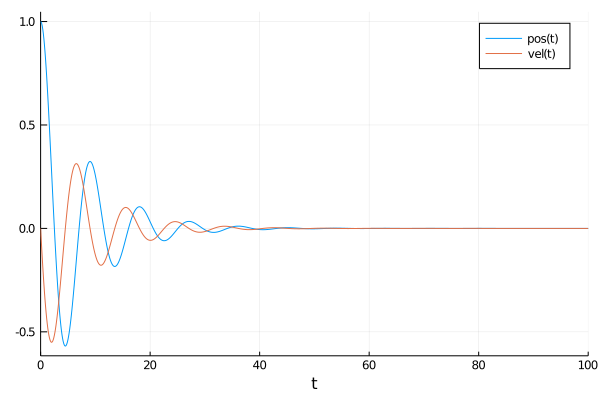

In [5]:
using OrdinaryDiffEq, Plots

prob = ODEProblem(od,ic,tspan,θs)
nom_sol = solve(prob,Tsit5())
plot(nom_sol)

### Building a cost function

You can make a cost function however you like. MinimallyDisruptiveCurves.jl only cares that the cost function has two methods:
```julia
function cost(params)
   ...
    return cost
end
```

```julia
function cost(params, gradient_holder)
   ...
    gradient_holder[:] = ...
    # MUTATE gradient_holder so gradient_holder = d(cost)/d(params
    return cost
end
```
But we will show you an easy way to do so, using DiffEqParamEstim.jl...

First, some background. A cost function is a mapping of the form:

> parameters -> how badly the model behaves

Now you have to choose what your measure of *badly behaved* constitutes. We are just going to take:

> parameters -> model -> sol -> |sol - nom_sol|^2 on a set of timepoints

So we are using `nom_sol` like experimental data, and taking our cost as the squared deviation from `nom_sol`.
Of course, you could use real data, or corrupt the output of `nom_sol` to make things more realistic.

How do we build the function? Well let's unroll the cost function:

> parameters -> simulate model -> solution -> cost_function(solution, nom_sol)

DiffEqParamEstim.jl has an excellent and flexible interface for creating cost functions. You give it a function of the form:
> solution -> cost_function(solution, ...)

and it will turn this into a differentiable cost function of the parameters, with the two methods specified in the previous paragraph.



In [6]:
using DiffEqParamEstim;
tsteps = tspan[1]:1.:tspan[end]
lossf(sol) = sum( [sum(abs2, el1 - el2) for (el1, el2) in zip(sol(tsteps).u, nom_sol(tsteps).u) ] )

# or instead use the equivalent convenience function, optimised for speed: 
lf = L2Loss(tsteps, nom_sol(tsteps).u)

L2Loss{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},Array{Array{Float64,1},2},Nothing,Nothing,Nothing}(0.0:1.0:100.0, [[1.0, 0.0] [0.7788756801266405, -0.4064801054625566] … [4.265124632750896e-6, 2.7021703038792645e-7] [3.524566585295755e-6, -1.5995341629349636e-6]], nothing, nothing, nothing, nothing)

In [8]:
cost = build_loss_objective(prob, Tsit5(), lossf; mpg_autodiff=true);

And that's it! ```cost``` is now a function with two methods. One evaluates the cost as a function of parameters. The other mutates an array with the same shape as the cost gradient. See for yourself:



In [26]:
θ₀ = last.(θs)
grad_template = deepcopy(θ₀);
@show cost(θ₀,grad_template)
@show grad_template;

cost(θ₀, grad_template) = 0.0
grad_template = [0.0003187019081444172, 4.117599081951138e-5, -0.00016964495177708563]


**Whoops!** 
- `cost(θ₀)` is a minimum, so we should have `grad_template = [0,0,0]`
- Numerical error will always massively corrupt the gradient (in relative terms) near a minimum, where the true gradient is very small.
- Don't worry, MinimallyDisruptiveCurves.jl has tricks up it's sleeve to deal with this!

### Initial direction for the MD curve

- We'll consider this more fully in different examples. For now, we'll be lazy and use the least minimally disruptive direction, to infinitesimal order, as our starting direction.
- How? For a small perturbation:
$$ C[\theta + \delta \theta] = C[\theta] + \delta \theta^T\nabla_{\theta}C[\theta] + \frac{1}{2} \delta \theta^T\nabla^2_{\theta}C[\theta] \delta \theta, $$
from Taylor's theorem.
- $\nabla_{\theta} C[\theta] = 0$ at the minimum, which gets rid of one term.
- $\nabla^2_{\theta}C[\theta] \succeq 0$ (is positive semidefinite).
So we just need to find a $\delta \theta$ corresponding to the smallest eigenvalue of $\nabla^2 C[\theta]$. 
- In this case, we will be lazy and just take a finite-difference approximation of the Hessian.
- You could replace FiniteDiff with ForwardDiff and run exactly the same code. It will be more accurate. But let's deliberately be a bit inaccurate here!

In [27]:
using FiniteDiff
#using ForwardDiff
H₀ = FiniteDiff.finite_difference_hessian(cost,θ₀)
# H₀ = ForwardDiff.hessian(cost, θ₀)
using LinearAlgebra
@show δθ₀ = eigen(H₀).vectors[:,1];

δθ₀ = (eigen(H₀)).vectors[:, 1] = [0.4364358391924533, 0.21821796688950507, 0.8728715124203504]


### Evolving a minimally disruptive curve

**NB: up to here is independent of MinimallyDisruptiveCurves.jl (but useful didactically (?) ). All you need to bring is a cost function, and an initial direction for the curve, as just described.**

First let's set the momentum. This is **the one hyperparameter** of the algorithm.
- Fortunately, the algorithm is (as far as I've seen) pretty robust to the choice of momentum.
- Once $ C(\theta) \geq mom $, the curve stops.
- A larger value of mom (marginally) speeds up curve evolution, and makes the trajectory (marginally) less curvy



In [11]:
mom = 1. 
span = (0., 100.);

Note we also set the desired curve length: `span`.

- If span[1] < 0, then two curves are evolved in parallel, pointing in the positive and negative directions of the initial direction, with lengths `abs(span[1]` and `abs(span[2])`.


Great! Now we have all the tools to build a curve! First we build a `curveProblem`. This is a struct that contains all the information necessary to generate a curve:

In [12]:
using MinimallyDisruptiveCurves
eprob = specify_curve(cost, θ₀, δθ₀, mom, span);

Now we can add some solving options. **For no reason in particular**, let's:
- Constrain parameters 1 and 3 to lie in the interval $[0, 1000]$
- Ask the solver to provide online output as the curve evolves, on the range 0.1:0.1:10

In [13]:
cb1 = ParameterBounds([1,3], [0.,0.], [1000.,1000.])
cb2 = VerboseOutput(:low, 0.1:2.:10)
cb = CallbackSet(cb1,cb2);

In [ ]:
@time mdc = evolve(eprob, Tsit5; callback=cb);

$<0.15$ seconds to run (the second time) on my laptop! Note that Julia has to precompile functions the first time round, which takes up some time.

### MD curve analysis

In different tutorials we will put more emphasis on post-curve analysis (both conceptually and by demonstrating helper functions in the codebase)

For now, let's just plot the curve:

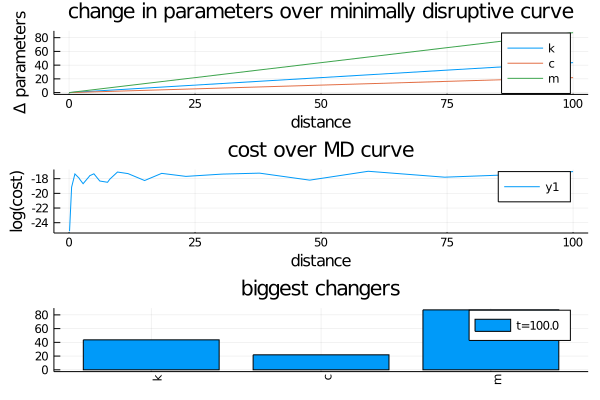

In [15]:
cc = [cost(el) for el in eachcol(trajectory(mdc))];
p1= plot(mdc; idxs=[1,2,3], pnames = first.(θs), what = :trajectory);
p2 = plot(distances(mdc), log.(cc), ylabel = "log(cost)", xlabel = "distance", title = "cost over MD curve");
p3 = plot(mdc; idxs=[1,2,3], pnames = first.(θs), what = :final_changes);
p = plot(p1,p2,p3, layout = (3,1))

Notice that the cost stays at numerical zero ($\leq exp(-18)$). As we predicted, the ratios $\frac{c}{m}$ and $\frac{k}{m}$ are preserved over the curve. 

Notice the numerical accuracy isn't shabby, given the degree of numerical error in calculations of the cost gradient!:

In [29]:
ratios = θ -> [θ[2]/θ[1] ,θ[3]/θ[1]]
@show ratios(θ₀)
@show ratios(mdc(100)[:states]);

ratios(θ₀) = [0.5, 2.0]
ratios((mdc(100))[:states]) = [0.5000063464797748, 2.0001151794552547]


### Summing different costs

Recall from the preliminary maths that the above minimally disruptive curve only holds in the unforced case, when $F(t) = 0$.

Let's now try to find a minimally disruptive curve that holds under **two** conditions:
- the unforced case
- a sinusoidal forcing term
So points on the minimally disruptive curve will correspond to parameters that minimally disrupt behaviour of the nominal system in both of these cases.

What do you imagine will happen? For nonzero $F(t)$ it looks clear that all parameters in

$$ m\ddot{x}(t) + c \dot{x}(t) + kx(t) = F(t). $$
will affect behaviour. One regime where the story might change a bit is when $m$ is large. Then:

\begin{align}
\ddot{x}(t) + \frac{c}{m}\dot{x}(t) + \frac{k}{m}x(t) &= \frac{F(t)}{m} \\
&\approx 0.
\end{align}

So if $m$ gets big, maybe the minimally disruptive curve will preserve $\frac{c}{m}$ and $\frac{k}{m}$? We will find out! 

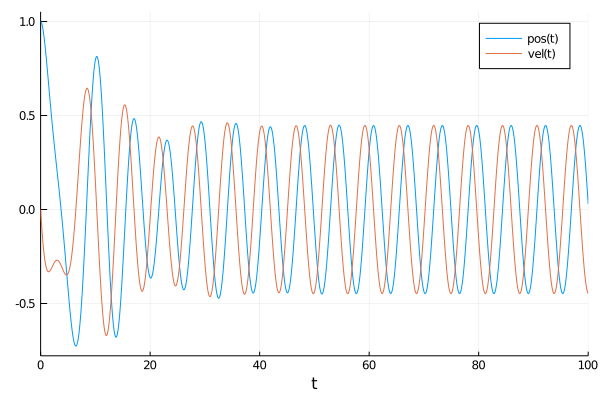

In [17]:
od2,_ , _ , _ = MassSpringOscillator(sin);
prob2 = ODEProblem(od2,ic,tspan,θs)
nom_sol2 = solve(prob2,Tsit5())
plot(nom_sol2)

In [18]:
lossf2(sol) = sum( [sum(abs2, el1 - el2) for (el1, el2) in zip(sol(tsteps).u, nom_sol2(tsteps).u) ] )
cost2 = build_loss_objective(prob2, Tsit5(), lossf2; mpg_autodiff=true);
summed_cost = sum_losses([cost, cost2], θ₀);

┌ Info: Note that restarting julia with multiple threads will increase performance of the generated loss function from sum_losses()
└ @ MinimallyDisruptiveCurves /Users/dhruvaraman/.julia/packages/MinimallyDisruptiveCurves/NyWwP/src/utilities/loss_algebra.jl:43


- Note that above we summed the two cost functions, using `sum_losses`. This works for **any** compatible cost functions. Doesn't matter how they are generated individually.

- If you restart julia with multiple threads, than evaluating each subcomponent of the summed cost runs on a separate thread, increasing speed.

In [19]:
H₁ = FiniteDiff.finite_difference_hessian(summed_cost,θ₀)
δθ₁ = eigen(H₁).vectors[:,1];

- We will change the momentum to 20., so that the curve doesn't terminate early (which it will if cost > mom.).
- We will change span so that span[1] < 0. This makes `evolve()` run an MDC curve in two initial directions (on separate threads if they exist). The $\pm$ directions of $d\theta_0$, to be precise.

In [ ]:
mom = 20.
span = (-100.,100.)
eprob2 = specify_curve(summed_cost, θ₀, δθ₁, mom, span);
cb1 = ParameterBounds([1,2,3], [0.,0.,0.], [1000.,1000.,1000.])
@time mdc2 = evolve(eprob2, Tsit5; callback=cb1);

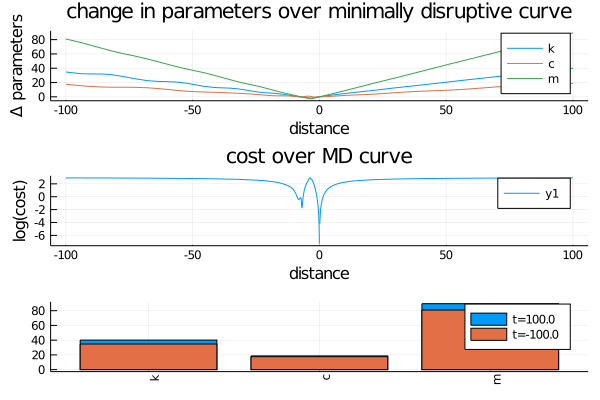

In [21]:
cc2 = [summed_cost(el) for el in eachcol(trajectory(mdc2))];
p1= plot(mdc2; idxs=[1,2,3], pnames = first.(θs), what = :trajectory);
p2 = plot(distances(mdc2), log.(cc2), ylabel = "log(cost)", xlabel = "distance", title = "cost over MD curve");
p3 = plot(mdc2; idxs=[1,2,3], pnames = first.(θs), what = :final_changes);
p = plot(p1,p2,p3, layout = (3,1))

- In **both** directions, the MDcurve eventually found a path that increased mass. Once mass is high, $F(t)$ is comparatively small.
- So basically, it couldn't change the parameters in a manner that truly kept the cost small. So it instead made the mass of the pendulum so large that $F(t)$ was insignificant. We can plot this to double check:

In [22]:
@show cost(mdc2(-100.)[:states])
@show cost2(mdc2(-100.)[:states])
@show summed_cost(mdc2(-100.)[:states]);

cost((mdc2(-100.0))[:states]) = 0.2631979978429595
cost2((mdc2(-100.0))[:states]) = 18.396528364811328
summed_cost((mdc2(-100.0))[:states]) = 18.659726362654286


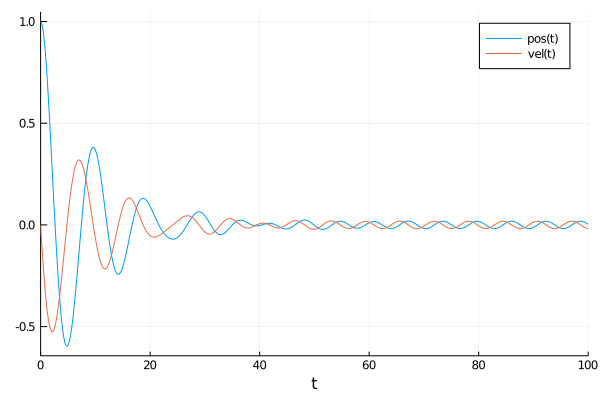

In [23]:
test_prob = remake(prob2, p = mdc2(100.)[:states])
ss = solve(test_prob, Tsit5())
plot(ss)